In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tk
from tensorflow import keras
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


2024-04-21 20:32:30.941130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 20:32:30.941208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 20:32:30.984875: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-21 20:32:31.062615: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 20:32:32.586816: W tensorflow/compiler/tf2

In [2]:
img_size = 96

def load_data(path, train=True):
    print("Loading data from: ", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1 # to_categorical encodes starting from 0
       
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append([ID, img_resize])
    return data

In [3]:
Altered_path = "SOCOFing/Altered"
Real_path = "SOCOFing/Real"

Altered_data = load_data(Altered_path, train=True)
Real_data = load_data(Real_path, train=False)


Loading data from:  SOCOFing/Altered
Loading data from:  SOCOFing/Real


## Creating two datasets, spoofing datasets and fingerNum datasets. 

In [4]:
for ad in Altered_data:
    ad[0]=1

In [5]:
for rd in Real_data:
    rd[0]=1

In [6]:
X_Altered, y_spoofing_Altered = [], []

for spoofing ,feature in Altered_data:
    X_Altered.append(feature)
    y_spoofing_Altered.append(spoofing)
    

X_Altered = np.array(X_Altered).reshape(-1, img_size, img_size, 1)
X_Altered = X_Altered / 255.0 # Normalize to [0, 1]
y_spoofing_Altered = to_categorical(y_spoofing_Altered, num_classes=2) # 600 persons in total


X_spoofing_train, X_spoofing_val, y_spoofing_train, y_spoofing_val = train_test_split(
    X_Altered, y_spoofing_Altered, test_size=0.2, random_state=2)


In [7]:
X_test, y_spoofing_test = [], []

for spoofing, feature in Real_data:
    X_test.append(feature)
    y_spoofing_test.append(spoofing)


X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

y_spoofing_test = to_categorical(y_spoofing_test, num_classes=2)


In [8]:
neural_networks = 1
model = [0] * neural_networks
final_Dense_units = [2]
model_name = ['spoofing_Model']

for i in range(neural_networks):
    input_layer = tf.keras.Input(shape=(96, 96, 1))
    x = layers.Conv2D(128, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)  # Adjusted dropout rate
    
    # Reshape and apply Global Average Pooling
    x = layers.Reshape((-1, 128))(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Dense Layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Adjusted dropout rate
    output_layer = layers.Dense(final_Dense_units[i], activation='softmax')(x)

    model[i] = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 92, 92, 128)       3328      
                                                                 
 batch_normalization (Batch  (None, 92, 92, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        36896     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 32)        128   

In [9]:

history = [0] * neural_networks
CallBack = [0] * neural_networks
ReduceLR_minlr = [-1e-2, -1e-3]
epochs = 5
batch_size = 64

for i in range(neural_networks):
    CallBack[i] = [
        EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1)
    ]

    history[i] = model[i].fit(X_spoofing_train, y_spoofing_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_data=(X_spoofing_val, y_spoofing_val),
                              verbose=1, callbacks=CallBack[i])


Epoch 1/5
214/214 [==============================] - 297s 1s/step - loss: 0.1112 - accuracy: 0.9800 - val_loss: 1.0254 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/5
214/214 [==============================] - 300s 1s/step - loss: 0.0492 - accuracy: 1.0000 - val_loss: 0.6768 - val_accuracy: 0.6517 - lr: 1.0000e-04
Epoch 3/5
214/214 [==============================] - 295s 1s/step - loss: 0.0438 - accuracy: 1.0000 - val_loss: 0.0465 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/5
214/214 [==============================] - 295s 1s/step - loss: 0.0389 - accuracy: 1.0000 - val_loss: 0.0365 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/5
214/214 [==============================] - 290s 1s/step - loss: 0.0343 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 1.0000 - lr: 1.0000e-04


fingerprint recognition accuracy:  100.0 %


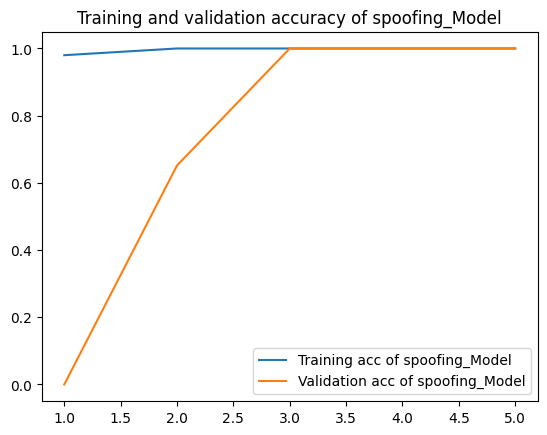

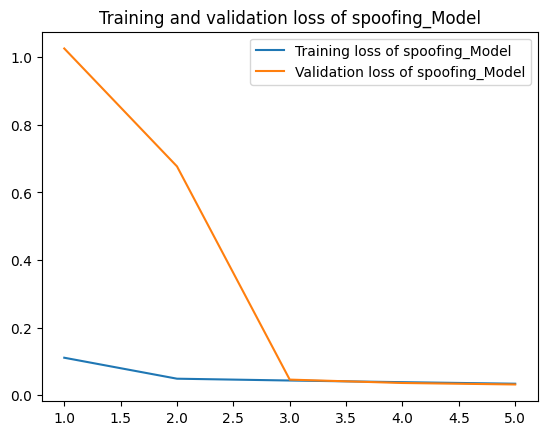

In [10]:
acc = [0] * neural_networks
val_acc = [0] * neural_networks
loss = [0] * neural_networks
val_loss = [0] * neural_networks
for i in range(neural_networks):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

testing_acc_Id = model[0].evaluate([X_test], [y_spoofing_test], verbose=0)
print("fingerprint recognition accuracy: ",testing_acc_Id[1]*100, "%")


## Visualize the predictions

188/188 [==============================] - 26s 136ms/step


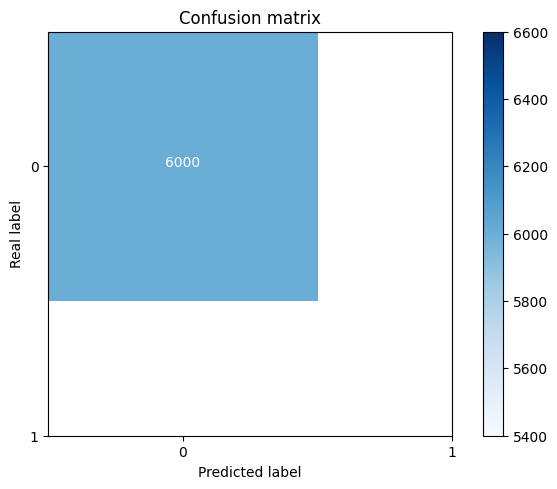

In [11]:

def plot_confusion_matrix(conmat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(conmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        conmat = conmat.astype('float') / conmat.sum(axis=1)[:, np.newaxis]

    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, conmat[i, j],
                 horizontalalignment="center",
                 color="white" if conmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

# Predict the values from the test dataset
y_spoofing_pred = model[0].predict(X_test)
# Convert predictions classes to one hot vectors 
y_spoofing_pred_classes = np.argmax(y_spoofing_pred, axis=1) 
# Convert test observations to one hot vectors
y_spoofing_real = np.argmax(y_spoofing_test, axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_spoofing_real, y_spoofing_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

188/188 [==============================] - 26s 139ms/step
Sample 1 : This fingerprint is real. Predicted class: 1
188/188 [==============================] - 26s 139ms/step
Sample 2 : This fingerprint is real. Predicted class: 1
188/188 [==============================] - 26s 139ms/step
Sample 3 : This fingerprint is real. Predicted class: 1
188/188 [==============================] - 26s 139ms/step
Sample 4 : This fingerprint is real. Predicted class: 1
188/188 [==============================] - 26s 139ms/step
Sample 5 : This fingerprint is real. Predicted class: 1
188/188 [==============================] - 26s 139ms/step
Sample 6 : This fingerprint is real. Predicted class: 1
188/188 [==============================] - 26s 140ms/step
Sample 7 : This fingerprint is real. Predicted class: 1
188/188 [==============================] - 26s 139ms/step
Sample 8 : This fingerprint is real. Predicted class: 1
188/188 [==============================] - 26s 139ms/step
Sample 9 : This fingerprint is

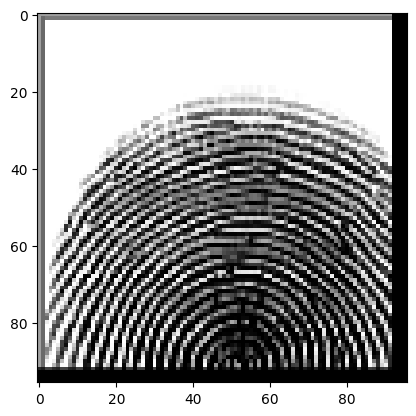

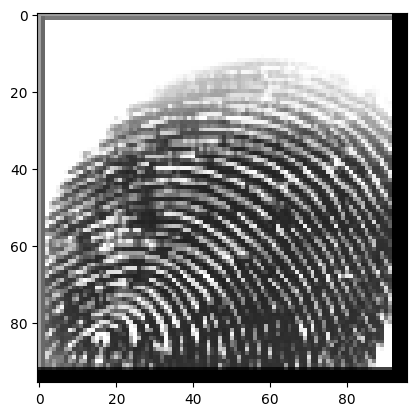

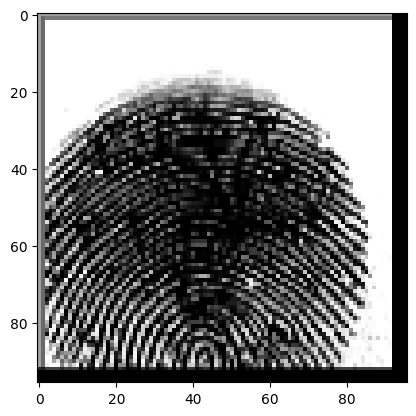

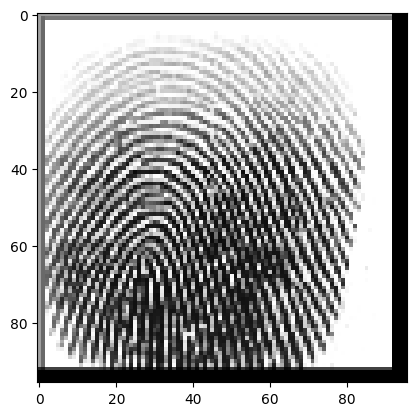

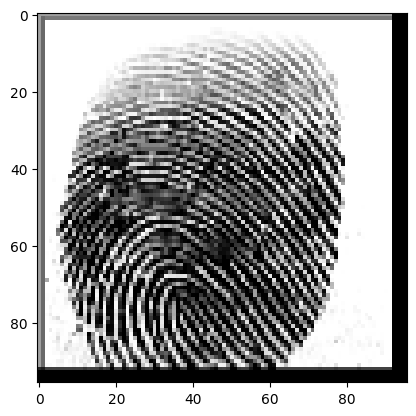

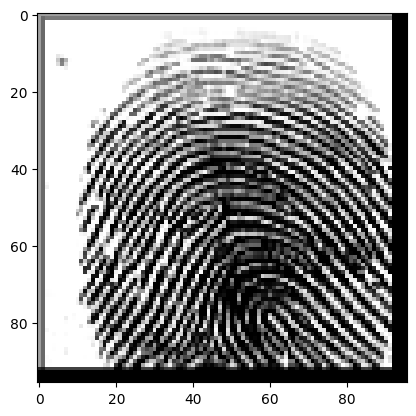

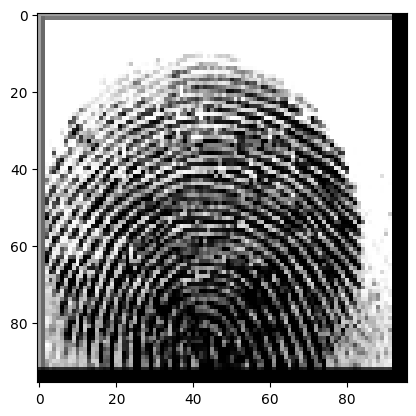

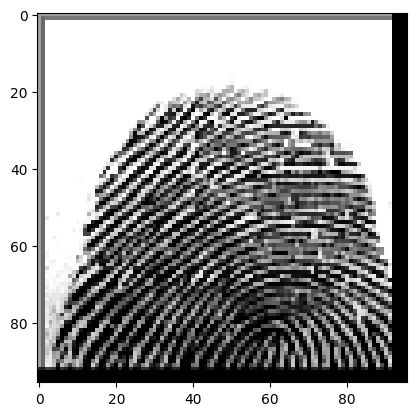

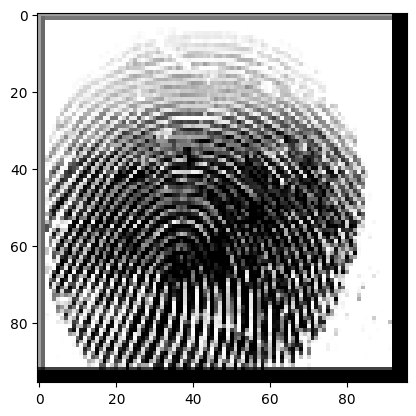

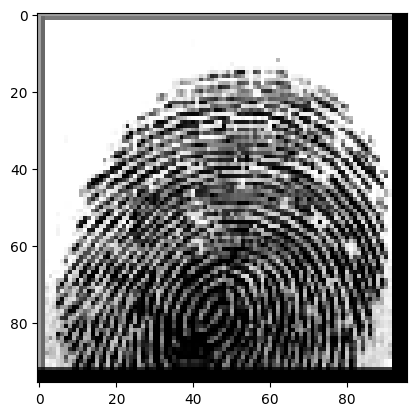

In [13]:
for i in range(10):
    rand_fp_num = i  # Select samples sequentially
    plt.figure()
    plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap='gray')
    y_spoofing_pred = model[0].predict(X_test)
    Id_pred = np.argmax(y_spoofing_pred[rand_fp_num])
    Id_real = np.argmax(y_spoofing_test[rand_fp_num])

    if Id_pred == Id_real:
        print("Sample", i+1, ": This fingerprint is real. Predicted class:", Id_pred)
    else:
        print("Sample", i+1, ": This fingerprint is fake! Predicted class:", Id_pred)

In [14]:
testing_acc_Id = model[0].evaluate([X_test], [y_spoofing_test], verbose=0)
print("Fingerprint recognition accuracy:", testing_acc_Id[1] * 100, "%")

Fingerprint recognition accuracy: 100.0 %


In [ ]:
e